# Finding the Best Spot in Berlin for Opening a Café cum Restaurant | Data Science Capstone Project

### Applied Data Science Capstone by IBM/Coursera

# Table of contents
* [Introduction](#introduction)
* [Data](#data)
* [Methodology and Exploratory Data Analysis](#methodology)
* [Results and Discussion](#ResultsDiscussion)
* [Conclusion](#Conclusion)
* [References](#References)

# 1. Introduction <a name="introduction"></a>

## 1.1 Background Discussion
Berlin is the largest city of Germany by both population and area. Its 3.77 million registered inhabitants also make it the most populous city of the European Union. Since 1990 after the fall of the Wall, Berlin is the capital of Germany and it established itself as a city of unlimited possibilities for travelers. The mixture of its historical significance, various festivals, diverse architecture, spectacular nightlife, and contemporary arts makes this city a magnet for tourists. Berlin’s 3.77 Million inhabitants are hosts to nearly 34 million overnight stays and 14 million visitors in year 2019 [1], which makes Berlin a top European destination – ranked third after London and Paris.

In addition, Berlin is also Europe’s leading economic force and its economy is growing rapidly for several years. In 2019, the nominal gross domestic product in Berlin was € 153.3 billion [2], which is 3% higher compared to the previous year and the number of people employed increased by 2.4% to more than 2 million [3].

All in all, the city’s rapidly growing economy, office businesses and tourisms make Berlin one of the best places to start up a new business, especially in Restaurants as the office businesses and the tourism are an important driver for restaurant industry.

## 1.2	Business Opportunity (Problem Description)
Now a days, most people, especially business employees, are eating more meals out of the home, because the work and lifestyle pressure often do not allow sufficient time for most of employees to prepare their own cuisine. Therefore, they rely on the Cafés and restaurants for their dietary needs, especially for breakfast and lunch. Similarly, tourist or business visitors also rely on the cafés and restaurants for their every meal. Berlin, where both the office businesses and tourism are growing rapidly since several years, provides huge opportunities for restaurant business. Reasonably priced restaurant in popular tourist and highly dense office places can attract both audiences – tourists and office employees. With given this scenario, we will analyze various factors to determine the best place in Berlin to open a café cum restaurant, where breakfast cum lunch or even brunch can be served. This report outlines some basic assumptions, data sets and data processing, and detailed analysis which can help us to select the best spot in Berlin for opening a café cum restaurant. In this procerss, we have assumed that money is not an issue for starting the business.

## 1.3	Target Audience
The key audience of this report would be anyone who wants to invest or open a restaurant in Berlin, or anyone in Berlin looking for a delicious breakfast, brunch, or lunch. The analysis will also help to office employees to find reasonable breakfast/lunch/brunch place close to office area.

# 2. Data <a name="data"></a>
In order to find best spot in Berlin, various set of data like boroughs, neighborhoods, area, population, number of registered companies, and number of visitors, etc. are required. Unfortunately, all sets of data are not available from any single source. Hence, the various sets of data are retrieved from different sources and Foursquare API is used to retrieve the venue data.

Altogether, below 4 sets of data are used for our analysis:
#### 1. <u>Berlin Boroughs, Neighborhoods, Area and Population Data</u> (see 3.1.1) 
* This set of data is going to help us to get lists of every neighborhoods of Berlin with their size of area, boroughs and population in each neighborhood. It will also help us to figure out the densely populated neighborhoods or boroughs in Berlin. This dataset is available on Wikipedia page – “Verwaltungsgliederung Berlins” [4]. From there, it is retrieved by scrapping the wiki page; and then pre-processed, cleaned, and converted it into Pandas data-frame.

#### 2. <u>Berlin Registered Business Data</u> (see 3.1.2)
 - This set of data is going to give us a rough indication of most busy areas of berlin by business employees, at least on the workdays, by providing the number of businesses located within each borough. This set of data is downloaded from “Amt für Statistik Berlin-Brandenburg” website in csv format [5] and placed into a pandas data frame.  

#### 3. <u>Berlin Registered Tourist Data</u> (see 3.1.3)
 - This set of data is going to give us a rough indication of most busy areas of berlin by tourists, by providing the number of visitors and overnight stays visitors within each Borough. This set of data is also downloaded from “Amt für Statistik Berlin-Brandenburg” website in csv format [5] and placed into a pandas data frame.

#### 4. <u>Rent or buying price of property in Berlin</u> (see 3.1.4)
 - Even though we have assumed that money is not an issue, the information about the rent or buying price of property can help us to give rough idea of how expensive it will be to maintain a café cum restaurant business in each neighborhoods or borough. Fortunately, we found the average rent price in € per month-m² in 2019 for each neighborhoods of Berlin from “Homeday – mein Immobilienmakler” website [6]. From there, the data is retrieved by scrapping the web page [6]; and then cleaned and converted it into Pandas data-frame. 

#### 5. <u>Foursquare API</u>
 - Foursquare data is robust, and it allows us to retrieve information about the most popular spots in each neighborhood/borough in Berlin. This can also help us to get idea about busy areas for particular venue types.

# 3. Methodology and Exploratory Data Analysis <a name="methodology"></a>

This section contains:
* 3.1 Data Scrapping, Wrangling, Cleaning and Processing
* 3.2 Merging Datasets and Importing the Geospatial Data
* 3.3 Foursquare Data Analysis
* 3.4 Neighborhood Clustering using K-Means Clustering

Starting with installing/importing the required libraries

In [1]:
import pandas as pd # library for data analsysis
import numpy as np # library to handle data in a vectorized manner
import random # library for random number generation
from bs4 import BeautifulSoup

!conda install -c conda-forge geopy --yes 
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

# libraries for displaying images
from IPython.display import Image 
from IPython.core.display import HTML 
from IPython.display import display_html
    
import requests # library to handle requests
from pandas.io.json import json_normalize # tranforming json file into a pandas dataframe library

# Matplotlib and associated plotting modules
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors

import seaborn as sns

# import k-means from clustering stage
from sklearn.cluster import KMeans

!conda install -c conda-forge folium=0.5.0 --yes
print('Folium installed')
import folium # map plotting library

print('Libraries imported.')

Solving environment: ...working... done

# All requested packages already installed.

Solving environment: ...working... done

# All requested packages already installed.

Folium installed
Libraries imported.


## 3.1 Data Scrapping, Wrangling,  Cleaning and Processing

### 3.1.1 Berlin Neighborhoods, Boroughs, Area and Population Data
#### Scrapping the Wiki page - Getting the data - Coverting into pandas dataframe

In [2]:
# Scrapping the wiki page
received_page = requests.get('https://de.wikipedia.org/wiki/Verwaltungsgliederung_Berlins').text
soup = BeautifulSoup(received_page,'lxml')

# Getting the data
berlin_RawData = soup.find_all('table', {'class':"wikitable sortable zebra"})[1]

# Making necessary Lists to prepare the table
num = [] # to store index
neighborhoods = [] #In German known as "Ortsteile"
boroughs = [] # In German known as "Bezirke"
population = []
area = []
popDensity = []
i = 0

# Store data into Lists
for index, row in enumerate(berlin_RawData.findAll("tr")):
    if len(row.findAll('td')) == 6:
        num.append(row.findAll('td')[0].text) # Index: not important
        neighborhoods.append(row.findAll('td')[1].find(text=True)) # 
        boroughs.append(row.findAll('td')[2].find(text=True))#
        area.append(row.findAll('td')[3].find(text=True))
        population.append(row.findAll('td')[4].find(text=True))
        popDensity.append(row.findAll('td')[5].find(text=True))
        i+=1

# Create Table
columnsTitle = ['Neighborhoods', 'Boroughs', 'Area_sqkm', 'Population', 'Population Density']
rowsData = list(zip(neighborhoods, boroughs, area, population, popDensity))

# Convert it into Pandas DataFrame
df_berlinNbrBrgh = pd.DataFrame(data = rowsData, columns = columnsTitle)
df_berlinNbrBrgh.index = np.arange(1, len(df_berlinNbrBrgh) + 1)
print("Data types of each columns:\n", df_berlinNbrBrgh.dtypes)
print("\nThe shape of df_berlinDist dataframe is:", df_berlinNbrBrgh.shape)
df_berlinNbrBrgh

Data types of each columns:
 Neighborhoods         object
Boroughs              object
Area_sqkm             object
Population            object
Population Density    object
dtype: object

The shape of df_berlinDist dataframe is: (96, 5)


,Neighborhoods,Boroughs,Area_sqkm,Population,Population Density
1,Mitte,Mitte,"10,70\n",101.932\n,9526\n
2,Moabit,Mitte,"7,72\n",79.512\n,10.299\n
3,Hansaviertel,Mitte,"0,53\n",5.894\n,11.121\n
4,Tiergarten,Mitte,"5,17\n",14.753\n,2854\n
5,Wedding,Mitte,"9,23\n",86.688\n,9392\n
...,...,...,...,...,...
92,Waidmannslust,Reinickendorf,"2,30\n",10.958\n,4764\n
93,Lübars,Reinickendorf,"5,00\n",5.174\n,1035\n
94,Wittenau,Reinickendorf,"5,90\n",24.306\n,4120\n
95,Märkisches Viertel,Reinickendorf,"3,20\n",40.258\n,12.581\n


#### Cleaning

Due to German Database Source, the "comma" represents the decimal separators whereas the "dot/point" represents the thousands separator.<br><br>Hence, our DataFrame requires below listed pre-processing (Data cleaning):
* **Population Column:** *Remove dots/points and trailing newlines (\n) and Change the data type to int data type*
* **Area_sqkm Column:** *Replace commas by dots/points, Remove \n and Change the data type to float data type*
* **Population Density Column:** *Remove dots and \n; and Change the data type to int data type*
* **Neighborhoods Column:** *Remove numerical digits, \n and initial space; and insert commas to separate Neighborhoods' names*

In [3]:
# Remove initial space in Boroughs
df_berlinNbrBrgh['Boroughs'].replace(' ', "", regex=True, inplace=True)

# Remove \n and replace commas (decimal separators) by dots (thousands separator) in Area_sqkm
df_berlinNbrBrgh['Area_sqkm'].replace(['\,', '\n'], [".", ""], regex=True, inplace=True)

# Remove dots (thousands separator) and trailing newlines in Population
df_berlinNbrBrgh['Population'].replace(r'\.|\n', "", regex=True, inplace=True)

# Remove dots (thousands separator) and trailing newlines in Population Density
df_berlinNbrBrgh['Population Density'].replace(['\.', '\,', '\n'], ["", ".", ""], regex=True, inplace=True)

# Change the data types for Population, Area_sqkm and Population Density
df_berlinNbrBrgh = df_berlinNbrBrgh.astype({"Population":int, "Area_sqkm":float, "Population Density":float})

#df_berlinNbrBrgh.to_csv('Berlin_NeighborhoodsBoroughsAreaPopulation.csv')

# Print DataType, shape and DataFrame
print("Data types of each columns:\n", df_berlinNbrBrgh.dtypes)
print("\nThe shape of dataframe is:", df_berlinNbrBrgh.shape)
print("Total numbers of Boroughs in Berlin are:", len(df_berlinNbrBrgh.groupby('Boroughs').size()))
print("Total numbers of Neighborhoods in Berlin are:", len(df_berlinNbrBrgh.groupby('Neighborhoods').size()))
df_berlinNbrBrgh

Data types of each columns:
 Neighborhoods          object
Boroughs               object
Area_sqkm             float64
Population              int32
Population Density    float64
dtype: object

The shape of dataframe is: (96, 5)
Total numbers of Boroughs in Berlin are: 12
Total numbers of Neighborhoods in Berlin are: 96


,Neighborhoods,Boroughs,Area_sqkm,Population,Population Density
1,Mitte,Mitte,10.70,101932,9526.0
2,Moabit,Mitte,7.72,79512,10299.0
3,Hansaviertel,Mitte,0.53,5894,11121.0
4,Tiergarten,Mitte,5.17,14753,2854.0
5,Wedding,Mitte,9.23,86688,9392.0
...,...,...,...,...,...
92,Waidmannslust,Reinickendorf,2.30,10958,4764.0
93,Lübars,Reinickendorf,5.00,5174,1035.0
94,Wittenau,Reinickendorf,5.90,24306,4120.0
95,Märkisches Viertel,Reinickendorf,3.20,40258,12581.0


#### Processing - grouping on boroughs
Since Registerd Business and Tourist Data are avaialbe for each borough rather than each neighborhoods, we reduce the df_berlinNbrBrgh according to boroughs by merging other parameters on boroughs.

In [4]:
# Get Table - Group Area, Population and Population Density on Boroughs as sum for Area and Population, as mean for Population Density  
df_boroughsAreaPopPopDen = df_berlinNbrBrgh.groupby(["Boroughs"]).agg({'Area_sqkm': np.sum, "Population":np.sum, 'Population Density':np.mean}).reset_index()

# Get Table - Group Neighborhoods on Boroughs and Join each neighborhoods with comma
df_boroughsNeighborhoods = df_berlinNbrBrgh.groupby(["Boroughs"])["Neighborhoods"].apply(", ".join).reset_index()

# Combine both Tables
df_berlinData = df_boroughsNeighborhoods.merge(df_boroughsAreaPopPopDen, on='Boroughs')
df_berlinData = df_berlinData.round(pd.Series([1], index=['Population Density']))
df_berlinData.index = np.arange(1, len(df_berlinData) + 1)

df_berlinData

,Boroughs,Neighborhoods,Area_sqkm,Population,Population Density
1,Charlottenburg-Wilmersdorf,"Charlottenburg, Wilmersdorf, Schmargendorf, Gr...",64.62,342332,7387.6
2,Friedrichshain-Kreuzberg,"Friedrichshain, Kreuzberg",20.18,289762,14342.0
3,Lichtenberg,"Friedrichsfelde, Karlshorst, Lichtenberg, Falk...",52.02,291452,5853.2
4,Marzahn-Hellersdorf,"Marzahn, Biesdorf, Kaulsdorf, Mahlsdorf, Helle...",61.71,268548,4492.4
5,Mitte,"Mitte, Moabit, Hansaviertel, Tiergarten, Weddi...",39.48,384172,9792.3
6,Neukölln,"Neukölln, Britz, Buckow, Rudow, Gropiusstadt",44.91,329691,8353.0
7,Pankow,"Prenzlauer Berg, Weißensee, Blankenburg, Heine...",103.26,407765,4219.2
8,Reinickendorf,"Reinickendorf, Tegel, Konradshöhe, Heiligensee...",89.40,265220,4022.7
9,Spandau,"Spandau, Haselhorst, Siemensstadt, Staaken, Ga...",91.90,243977,3023.5
10,Steglitz-Zehlendorf,"Steglitz, Lichterfelde, Lankwitz, Zehlendorf, ...",102.47,308697,4074.6


### 3.1.2 Berlin Registered Business Data
#### Getting the data  and Coverting into pandas dataframe
Data is downloaded from website of “Statistical Office Berlin-Brandenburg” in csv format and saved it as 'EmployeeSizeClasses-BerlinDistricts-2018.csv'. 

In [5]:
# Load data from file and convert it into Pandas DataFrame
df_berlinBusinesses = pd.read_csv('EmployeeSizeClasses-BerlinDistricts-2018.csv', index_col=[0])
df_berlinBusinesses

,Boroughs,Businesses with employee size 0-9,Businesses with employee size 10-49,Businesses with employee size 50-249,Businesses with employee size 250 or more
1,Mitte,24251,3223,869,210
2,Friedrichshain-Kreuzberg,18874,1679,356,69
3,Pankow,20985,1313,267,63
4,Charlottenburg-Wilmersdorf,26373,2357,506,88
5,Spandau,6975,538,146,33
6,Steglitz-Zehlendorf,13309,869,182,40
7,Tempelhof-Schöneberg,16918,1593,340,75
8,Neukölln,11458,856,164,33
9,Treptow-Köpenick,10189,912,187,28
10,Marzahn-Hellersdorf,6843,660,147,22


#### Processing - Sum up all Businesses

In [6]:
# Sum up all slabs-businesses column into "Total Businesses" and delete all businesses-slabs columns

# List of Columns to be deleted
columnsToDelete = ['Businesses with employee size 0-9','Businesses with employee size 10-49',
                   'Businesses with employee size 50-249','Businesses with employee size 250 or more']

# Sum up all businesses into "Total Businesses"
df_berlinBusinesses["Total Businesses"] = df_berlinBusinesses[columnsToDelete].sum(axis=1)

# Delete all slabs columns
df_berlinBusinesses.drop(columnsToDelete, axis = 1, inplace = True)
df_berlinBusinesses.sort_values(by = ['Total Businesses'], ascending = False, inplace=True)
df_berlinBusinesses.index = np.arange(1, len(df_berlinBusinesses) + 1)

# Print DataType, shape and DataFrame
print("Data types of each columns:\n", df_berlinBusinesses.dtypes)
print("\nThe shape of dataframe is:", df_berlinBusinesses.shape)
print("Total numbers of registered businesses in Berlin are:", df_berlinBusinesses['Total Businesses'].sum(axis=0))
df_berlinBusinesses

Data types of each columns:
 Boroughs            object
Total Businesses     int64
dtype: object

The shape of dataframe is: (12, 2)
Total numbers of registered businesses in Berlin are: 192199


,Boroughs,Total Businesses
1,Charlottenburg-Wilmersdorf,29324
2,Mitte,28553
3,Pankow,22628
4,Friedrichshain-Kreuzberg,20978
5,Tempelhof-Schöneberg,18926
6,Steglitz-Zehlendorf,14400
7,Neukölln,12511
8,Treptow-Köpenick,11316
9,Reinickendorf,9966
10,Lichtenberg,8233


### 3.1.3 Berlin Registered Tourist Data
#### Getting the data  and Coverting into pandas dataframe
Data is downloaded from website of “Statistical Office Berlin-Brandenburg” in csv format and saved it as 'TourismusBerlin-2019.csv'. 

In [7]:
# Load data from file and convert it into Pandas DataFrame
df_berlinTourist = pd.read_csv('TourismusBerlin-2019.csv', index_col=[0])
df_berlinTourist

,Boroughs,Visitors in 2019,Overnight stays visitors in 2019
1,Mitte,6069884,14739386
2,Friedrichshain-Kreuzberg,1820781,4675128
3,Pankow,512864,1411473
4,Charlottenburg-Wilmersdorf,2698392,6459041
5,Spandau,271317,606062
6,Steglitz-Zehlendorf,211835,499837
7,Tempelhof-Schöneberg,838509,2109597
8,Neukölln,407795,923404
9,Treptow-Köpenick,300587,651275
10,Marzahn-Hellersdorf,92516,263915


#### Processing - Sum up Visitors and Overnight stays visitors in 2019

In [8]:
# Sum up Guests and Overnight stays guests as Total Visitors and delete Guests and Overnight stays guests columns
columnsToDelFromTouristData = ['Visitors in 2019', 'Overnight stays visitors in 2019']

df_berlinTourist["Total Visitors in 2019"] = df_berlinTourist[columnsToDelFromTouristData].sum(axis=1)

df_berlinTourist.drop(columnsToDelFromTouristData, axis=1, inplace=True)
df_berlinTourist.sort_values(by = ['Total Visitors in 2019'], ascending = False, inplace=True)
df_berlinTourist.index = np.arange(1, len(df_berlinTourist) + 1)

# Print DataType, shape and DataFrame
print("Data types of each columns:\n", df_berlinTourist.dtypes)
print("\nThe shape of dataframe is:", df_berlinTourist.shape)
print("Total numbers of tourists visited Berlin in year 2019 are:", df_berlinTourist['Total Visitors in 2019'].sum(axis=0))
df_berlinTourist

Data types of each columns:
 Boroughs                  object
Total Visitors in 2019     int64
dtype: object

The shape of dataframe is: (12, 2)
Total numbers of tourists visited Berlin in year 2019 are: 48087709


,Boroughs,Total Visitors in 2019
1,Mitte,20809270
2,Charlottenburg-Wilmersdorf,9157433
3,Friedrichshain-Kreuzberg,6495909
4,Tempelhof-Schöneberg,2948106
5,Pankow,1924337
6,Lichtenberg,1791645
7,Neukölln,1331199
8,Treptow-Köpenick,951862
9,Spandau,877379
10,Reinickendorf,732466


### 3.1.4 Rent or buying price of property in Berlin
#### Scrapping the Wiki page - Getting the data - Coverting into pandas dataframe

In [9]:
# Scrapping the wiki page
received_page_homdayDe = requests.get('https://www.homeday.de/de/blog/mietpreise-berlin-2019').text
soupHomedayDe = BeautifulSoup(received_page_homdayDe,'lxml')

# Getting the data
berlin_RentPrice = soupHomedayDe.find('table')

# Making necessary Lists to prepare the table
neighborhoods = [] #In German known as "Ortsteile"
rentPricePerSqm_2016 = []
rentPricePerSqm_2019 = []
priceChange = []
i = 0
for index, row in enumerate(berlin_RentPrice.findAll("tr")):
    if len(row.findAll('td')) == 4:
        neighborhoods.append(row.findAll('td')[0].text)
        rentPricePerSqm_2016.append(row.findAll('td')[1].find(text=True))
        rentPricePerSqm_2019.append(row.findAll('td')[2].find(text=True))
        priceChange.append(row.findAll('td')[3].find(text=True))
        i+=1

# Create Table - we need only Neighhborhoods and Rent price in year 2019.             
columnsTitle_rentPrice = ['Neighborhoods', 'Rent Price in 2019 [€/m²-month]']
rowsData_rentPrice = list(zip(neighborhoods, rentPricePerSqm_2019))

df_berlinRentPrice = pd.DataFrame(data = rowsData_rentPrice, columns = columnsTitle_rentPrice)
df_berlinRentPrice.index = np.arange(1, len(df_berlinRentPrice) + 1)
print("Data types of each columns:\n", df_berlinRentPrice.dtypes)
print("\nThe shape of df_berlinDist dataframe is:", df_berlinRentPrice.shape)
df_berlinRentPrice

Data types of each columns:
 Neighborhoods                      object
Rent Price in 2019 [€/m²-month]    object
dtype: object

The shape of df_berlinDist dataframe is: (96, 2)


,Neighborhoods,Rent Price in 2019 [€/m²-month]
1,Tiergarten,"14,00 €"
2,Friedrichshain,"13,60 €"
3,Grunewald,"13,00 €"
4,Rummelsburg,"13,00 €"
5,Moabit,"12,60 €"
...,...,...
92,Neu-Hohenschönhausen,"8,00 €"
93,Hellersdorf,"7,90 €"
94,Falkenberg,"7,50 €"
95,Marzahn,"7,30 €"


#### Cleaning 

Due to German Database Source, the "comma" represents the decimal separators whereas the "dot/point" represents the thousands separator.<br><br>Hence, our DataFrame requires below listed pre-processing (Data cleaning):
* **Rent Price in 2019 [€/m²-mont] Column:** *Replace commas by dots/points, Remove € sign and Change the data type to float data type*

In [10]:
# Remove dots (thousands separator) and trailing newlines in Population
df_berlinRentPrice['Rent Price in 2019 [€/m²-month]'].replace(['\,', ' €'], [".", ""], regex=True, inplace=True)

# Change the data types for Population, Area_sqkm and Population Density
df_berlinRentPrice = df_berlinRentPrice.astype({"Rent Price in 2019 [€/m²-month]":float})

#df_berlinRentPrice.to_csv('Berlin_NeighbouthoodsRentPrice2019.csv')

# Print DataType, shape and DataFrame
print("Data types of each columns:\n", df_berlinRentPrice.dtypes)
print("\nThe shape of df_berlin dataframe is:", df_berlinRentPrice.shape)
df_berlinRentPrice

Data types of each columns:
 Neighborhoods                       object
Rent Price in 2019 [€/m²-month]    float64
dtype: object

The shape of df_berlin dataframe is: (96, 2)


,Neighborhoods,Rent Price in 2019 [€/m²-month]
1,Tiergarten,14.0
2,Friedrichshain,13.6
3,Grunewald,13.0
4,Rummelsburg,13.0
5,Moabit,12.6
...,...,...
92,Neu-Hohenschönhausen,8.0
93,Hellersdorf,7.9
94,Falkenberg,7.5
95,Marzahn,7.3


#### Processing - grouping on boroughs
Since Registerd Business and Tourist Data are avaialbe for each borough rather than each neighborhoods, we group the Rent Price data on to boroughs from the neighborhoods.

In [11]:
# Get neighborhoods and boroughs
df_berlinNeighborhoodsBoroughs = df_berlinNbrBrgh.loc[:,['Neighborhoods', 'Boroughs']]

# Merge boroughs into Rent Price dataframe
df_berlinBoroughRentPrice = df_berlinNeighborhoodsBoroughs.merge(df_berlinRentPrice, on='Neighborhoods')
df_berlinBoroughRentPrice.index = np.arange(1, len(df_berlinBoroughRentPrice) + 1)

# Neighborhoods and Rent Price group by boroughs; Rent Price as average or maximum for boroughs 
df_berlinBoroughRentPriceTemp = df_berlinBoroughRentPrice.groupby(["Boroughs"]).agg({'Rent Price in 2019 [€/m²-month]':np.max}).reset_index()
df_NeighborhoodsByBoroughs = df_berlinBoroughRentPrice.groupby(["Boroughs"])["Neighborhoods"].apply(", ".join).reset_index()
df_berlinBoroughRentPrice = df_NeighborhoodsByBoroughs.merge(df_berlinBoroughRentPriceTemp, on='Boroughs')

# Round up the Rent Price values,sort in descending order and start index from 1
df_berlinBoroughRentPrice = df_berlinBoroughRentPrice.round(pd.Series([1], index=['Rent Price in 2019 [€/m²-month]'])) # df_berlinBoroughRentPrice.sort_values(by=['Rent Price in 2019 [€/m²-month]'], inplace=True, ascending=False)
df_berlinBoroughRentPrice.sort_values(by=['Rent Price in 2019 [€/m²-month]'], inplace=True, ascending=False)
df_berlinBoroughRentPrice.index = np.arange(1, len(df_berlinBoroughRentPrice) + 1)

#df_berlinBoroughRentPrice.to_csv('Berlin_Boroughs_RentPrice.csv')

# Print DataType, shape and DataFrame
print("Data types of each columns:\n", df_berlinBoroughRentPrice.dtypes)
print("\nThe shape of dataFrame is:", df_berlinBoroughRentPrice.shape)
df_berlinBoroughRentPrice

Data types of each columns:
 Boroughs                            object
Neighborhoods                       object
Rent Price in 2019 [€/m²-month]    float64
dtype: object

The shape of dataFrame is: (12, 3)


,Boroughs,Neighborhoods,Rent Price in 2019 [€/m²-month]
1,Mitte,"Mitte, Moabit, Hansaviertel, Tiergarten, Weddi...",14.0
2,Friedrichshain-Kreuzberg,"Friedrichshain, Kreuzberg",13.6
3,Charlottenburg-Wilmersdorf,"Charlottenburg, Wilmersdorf, Schmargendorf, Gr...",13.0
4,Lichtenberg,"Friedrichsfelde, Karlshorst, Lichtenberg, Falk...",13.0
5,Steglitz-Zehlendorf,"Steglitz, Lichterfelde, Lankwitz, Zehlendorf, ...",12.4
6,Pankow,"Prenzlauer Berg, Weißensee, Blankenburg, Heine...",12.1
7,Tempelhof-Schöneberg,"Schöneberg, Friedenau, Tempelhof, Mariendorf, ...",11.8
8,Treptow-Köpenick,"Alt-Treptow, Plänterwald, Baumschulenweg, Joha...",11.6
9,Reinickendorf,"Reinickendorf, Tegel, Konradshöhe, Heiligensee...",10.0
10,Spandau,"Spandau, Haselhorst, Siemensstadt, Staaken, Ga...",10.0


## 3.2 Merging Datasets and Importing the Geospatial Data

### 3.2.1 Merging Datasets

Now, as Tourist and Business dataset are only available for each borough, merge all data sets on 'Boroughs' and put it into one data frame - **df_berlin**.

In [12]:
# Merge the Business data set with Berlin data set on Boroughs
df_berlin = df_berlinData.merge(df_berlinBusinesses, on = 'Boroughs')

# Merge the Tourist data with latest Berlin data set on Boroughs
df_berlin = df_berlin.merge(df_berlinTourist, on = 'Boroughs')

#Merge the Rent Price data set with latest Berlin data set on Boroughs and Neighborhoods
#df_berlin = df_berlinData.merge(df_berlinBoroughRentPrice[['Boroughs', 'Rent Price in 2019 [€/m²-month]']], on = 'Boroughs')
df_berlin = df_berlin.merge(df_berlinBoroughRentPrice, on = ['Boroughs','Neighborhoods'])

# Now all datasets are merged into one data frame called df_berlin.
df_berlin.index = np.arange(1, len(df_berlin) + 1)


# Removing Population Density, as it is not necessary for further study
df_berlin.drop(columns=['Population Density'], axis=1, inplace=True)

# Print DataType, shape and DataFrame called df_berlin
print("Data types of each columns:\n", df_berlin.dtypes)
print("\nThe shape of dataFrame is:", df_berlin.shape)
df_berlin

Data types of each columns:
 Boroughs                            object
Neighborhoods                       object
Area_sqkm                          float64
Population                           int32
Total Businesses                     int64
Total Visitors in 2019               int64
Rent Price in 2019 [€/m²-month]    float64
dtype: object

The shape of dataFrame is: (12, 7)


,Boroughs,Neighborhoods,Area_sqkm,Population,Total Businesses,Total Visitors in 2019,Rent Price in 2019 [€/m²-month]
1,Charlottenburg-Wilmersdorf,"Charlottenburg, Wilmersdorf, Schmargendorf, Gr...",64.62,342332,29324,9157433,13.0
2,Friedrichshain-Kreuzberg,"Friedrichshain, Kreuzberg",20.18,289762,20978,6495909,13.6
3,Lichtenberg,"Friedrichsfelde, Karlshorst, Lichtenberg, Falk...",52.02,291452,8233,1791645,13.0
4,Marzahn-Hellersdorf,"Marzahn, Biesdorf, Kaulsdorf, Mahlsdorf, Helle...",61.71,268548,7672,356431,9.8
5,Mitte,"Mitte, Moabit, Hansaviertel, Tiergarten, Weddi...",39.48,384172,28553,20809270,14.0
6,Neukölln,"Neukölln, Britz, Buckow, Rudow, Gropiusstadt",44.91,329691,12511,1331199,9.3
7,Pankow,"Prenzlauer Berg, Weißensee, Blankenburg, Heine...",103.26,407765,22628,1924337,12.1
8,Reinickendorf,"Reinickendorf, Tegel, Konradshöhe, Heiligensee...",89.40,265220,9966,732466,10.0
9,Spandau,"Spandau, Haselhorst, Siemensstadt, Staaken, Ga...",91.90,243977,7692,877379,10.0
10,Steglitz-Zehlendorf,"Steglitz, Lichterfelde, Lankwitz, Zehlendorf, ...",102.47,308697,14400,711672,12.4


### 3.2.2 Importing and Merging the Geospatial Data
Adding the geographical coordinates of the Boroughs using geopy geocoders

In [13]:
# use of geopy geocoders
#from geopy.geocoders import Nominatim
geolocator = Nominatim(user_agent="Berlin_explorer")
df_berlin['Boroughs_Coord']= df_berlin['Boroughs'].apply(geolocator.geocode).apply(lambda x: (x.latitude, x.longitude))
df_berlin[['Latitude', 'Longitude']] = df_berlin['Boroughs_Coord'].apply(pd.Series)

df_berlin.drop(['Boroughs_Coord'], axis=1, inplace=True)
df_berlin


,Boroughs,Neighborhoods,Area_sqkm,Population,Total Businesses,Total Visitors in 2019,Rent Price in 2019 [€/m²-month],Latitude,Longitude
1,Charlottenburg-Wilmersdorf,"Charlottenburg, Wilmersdorf, Schmargendorf, Gr...",64.62,342332,29324,9157433,13.0,52.507856,13.263952
2,Friedrichshain-Kreuzberg,"Friedrichshain, Kreuzberg",20.18,289762,20978,6495909,13.6,52.515306,13.461612
3,Lichtenberg,"Friedrichsfelde, Karlshorst, Lichtenberg, Falk...",52.02,291452,8233,1791645,13.0,48.921296,7.481227
4,Marzahn-Hellersdorf,"Marzahn, Biesdorf, Kaulsdorf, Mahlsdorf, Helle...",61.71,268548,7672,356431,9.8,52.522523,13.587663
5,Mitte,"Mitte, Moabit, Hansaviertel, Tiergarten, Weddi...",39.48,384172,28553,20809270,14.0,52.517690,13.402376
6,Neukölln,"Neukölln, Britz, Buckow, Rudow, Gropiusstadt",44.91,329691,12511,1331199,9.3,52.481150,13.435350
7,Pankow,"Prenzlauer Berg, Weißensee, Blankenburg, Heine...",103.26,407765,22628,1924337,12.1,52.597637,13.436374
8,Reinickendorf,"Reinickendorf, Tegel, Konradshöhe, Heiligensee...",89.40,265220,9966,732466,10.0,52.604763,13.295287
9,Spandau,"Spandau, Haselhorst, Siemensstadt, Staaken, Ga...",91.90,243977,7692,877379,10.0,52.535788,13.197792
10,Steglitz-Zehlendorf,"Steglitz, Lichterfelde, Lankwitz, Zehlendorf, ...",102.47,308697,14400,711672,12.4,52.429205,13.229974


Based on google search, the longitude and latitude data for Lichtenberg Borough are completly wrong and other boroughs' data are also slighlty different compared the data from google. So we replace the longitude and latitude for all boroughs with the google data, which is stored in "BerlinBoroughsLatitudeLongitude.csv" file. 

In [14]:
df_berlin.drop(['Latitude', 'Longitude'], axis = 1, inplace=True)
df_berlinBoroughsLatLng = pd.read_csv('BerlinBoroughsLatitudeLongitude.csv', index_col=[0])
df_berlin = df_berlin.merge(df_berlinBoroughsLatLng, on='Boroughs')
df_berlin.index = np.arange(1, len(df_berlin) + 1)
df_berlin

,Boroughs,Neighborhoods,Area_sqkm,Population,Total Businesses,Total Visitors in 2019,Rent Price in 2019 [€/m²-month],Latitude,Longitude
1,Charlottenburg-Wilmersdorf,"Charlottenburg, Wilmersdorf, Schmargendorf, Gr...",64.62,342332,29324,9157433,13.0,52.498889,13.284917
2,Friedrichshain-Kreuzberg,"Friedrichshain, Kreuzberg",20.18,289762,20978,6495909,13.6,52.500000,13.433333
3,Lichtenberg,"Friedrichsfelde, Karlshorst, Lichtenberg, Falk...",52.02,291452,8233,1791645,13.0,52.533333,13.500000
4,Marzahn-Hellersdorf,"Marzahn, Biesdorf, Kaulsdorf, Mahlsdorf, Helle...",61.71,268548,7672,356431,9.8,52.539720,13.584280
5,Mitte,"Mitte, Moabit, Hansaviertel, Tiergarten, Weddi...",39.48,384172,28553,20809270,14.0,52.516667,13.366667
6,Neukölln,"Neukölln, Britz, Buckow, Rudow, Gropiusstadt",44.91,329691,12511,1331199,9.3,52.483333,13.450000
7,Pankow,"Prenzlauer Berg, Weißensee, Blankenburg, Heine...",103.26,407765,22628,1924337,12.1,52.568889,13.402222
8,Reinickendorf,"Reinickendorf, Tegel, Konradshöhe, Heiligensee...",89.40,265220,9966,732466,10.0,52.566667,13.350000
9,Spandau,"Spandau, Haselhorst, Siemensstadt, Staaken, Ga...",91.90,243977,7692,877379,10.0,52.533333,13.166667
10,Steglitz-Zehlendorf,"Steglitz, Lichterfelde, Lankwitz, Zehlendorf, ...",102.47,308697,14400,711672,12.4,52.433333,13.250000


## 3.3 Narrowing Down Boroughs and Visulazing using Folium

### 3.3.1 Narrowing Down Boroughs

In order to narrowing down boroughs, first we visualize our data sets for three parameters: Boroughs Vs. Businesses, Boroughs Vs. Tourists, Boroughs Vs. Rent Price.

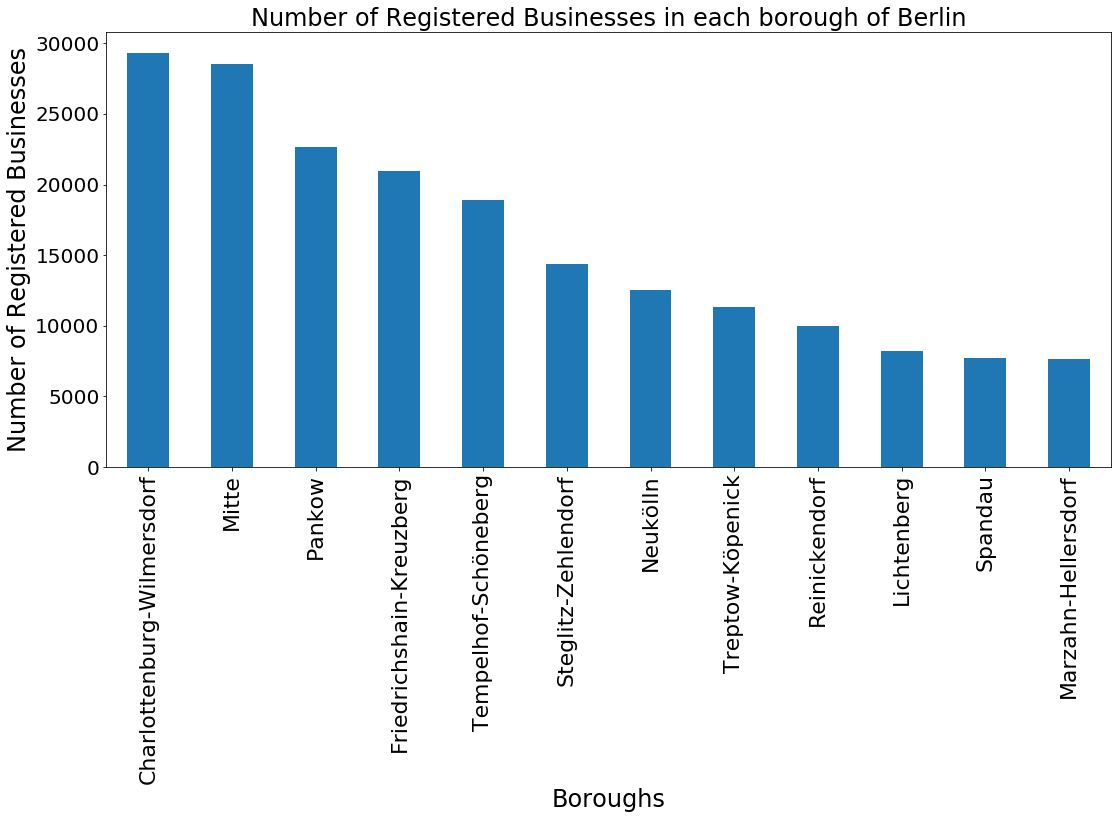

In [15]:
# Plot the bar graph for Boroughs Vs. number of Businesses
df_berlinBusinessPlot = df_berlin.sort_values(by=['Total Businesses'], ascending=False)
#df_berlinBusinessPlot.plot.bar(x = 'Boroughs', y = 'Total Businesses', title = "Number of Registered Businesses in each brough of Berlin", legend = None, rot= 45, figsize = (18, 8), color=['darkslategray','darkcyan','darkturquoise','cadetblue', 'powderblue','lightblue','deepskyblue','skyblue','lightskyblue','steelblue'])
df_berlinBusinessPlot.plot.bar(x = 'Boroughs', y = 'Total Businesses', title = "Number of Registered Businesses in each brough of Berlin", legend = None, rot= 45, figsize = (18, 8))
plt.ylabel('Number of Registered Businesses', fontsize=24)
plt.yticks(fontsize=20)
plt.xticks(rotation=90, fontsize=22)
plt.xlabel('Boroughs', fontsize=24)
plt.title('Number of Registered Businesses in each borough of Berlin', fontsize = 24)
plt.show()

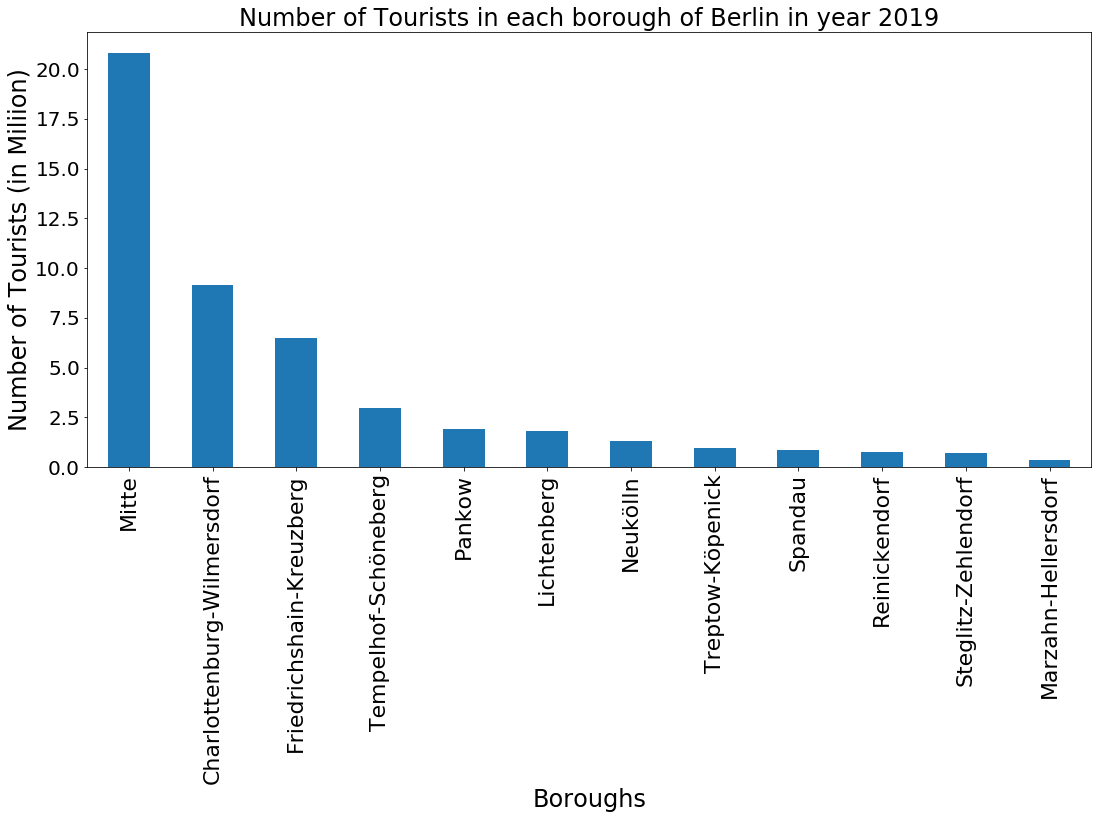

In [16]:
# Plot the bar graph for Boroughs Vs. Total Visitors in each Borough
df_berlinTouristPlot = df_berlin.sort_values(by=['Total Visitors in 2019'], ascending=False)
df_berlinTouristPlot['Total Visitors in 2019'] = df_berlinTouristPlot['Total Visitors in 2019']/1000000
#df_berlinTouristPlot.plot.bar(x = 'Boroughs', y = 'Total Visitors in 2019', title = "Number of Tourists in Berlin in year 2019", legend = None, rot= 45, figsize = (18, 8), color=['darkslategray','darkcyan','darkturquoise','cadetblue', 'powderblue','lightblue','deepskyblue','skyblue','lightskyblue','steelblue'])
df_berlinTouristPlot.plot.bar(x = 'Boroughs', y = 'Total Visitors in 2019', title = "Number of Tourists in Berlin in year 2019", legend = None, rot= 45, figsize = (18, 8))
plt.ylabel('Number of Tourists (in Miliion)', fontsize=24)
plt.yticks(fontsize=20)
plt.xticks(rotation=90, fontsize=22)
plt.xlabel('Boroughs', fontsize=24)
plt.title('Number of Tourists in each borough of Berlin in year 2019', fontsize = 24)
plt.show()

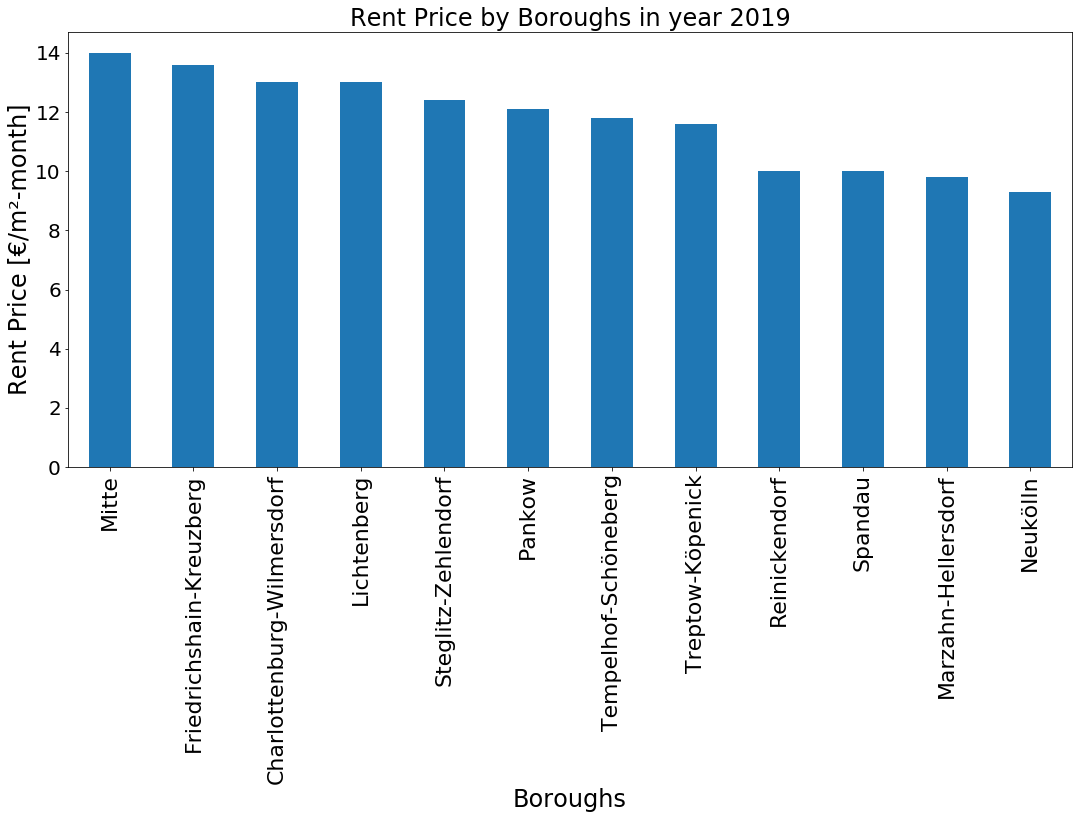

In [17]:
# Plot the bar graph for Boroughs Vs. Rent Price in each Borough
df_berlinRentPricePlot = df_berlin.sort_values(by=['Rent Price in 2019 [€/m²-month]'], ascending=False)
#df_berlinRentPricePlot.plot.bar(x = 'Boroughs', y = 'Rent Price in 2019 [€/m²-month]', title = "Rent Price in 2019 by Boroughs", legend = None, rot= 45, figsize = (18, 8), color=['darkslategray','darkcyan','darkturquoise','cadetblue', 'powderblue','lightblue','deepskyblue','skyblue','lightskyblue','steelblue'])
df_berlinRentPricePlot.plot.bar(x = 'Boroughs', y = 'Rent Price in 2019 [€/m²-month]', title = "Rent Price in 2019 by Boroughs", legend = None, rot= 45, figsize = (18, 8))
plt.ylabel('Rent Price [€/m²-month]', fontsize=24)
plt.yticks(fontsize=20)
plt.xticks(rotation=90, fontsize=22)
plt.xlabel('Boroughs', fontsize=24)
plt.title('Rent Price by Boroughs in year 2019', fontsize = 24)
plt.show()

As mentioned earlier that money is not an issue, hence, our selection of boroughs will be only based on number of Businesses and Tourist in each borough.<br><br>Based on Businesses and Tourist data, one can see that:
* **62.7%** of total businesses are existing only in 5 Boroughs. Out of 5 boroughs, both **Charlottenburg-Wilmersdorf** and **Mitte** boroughs have **30%** of total businesses, whereas **Pankow, Friedrichshain-Kreuzberg** and **Tempelhof-Schöneberg** boroughs cover another **31.7%** of total businesses.
* **86%** of total Tourists have either visited or stayed over night in 5 Boroughs. Out of those tourists, **43%** of tourists are only hosted by **Mitte** borough, whereas another **43%** are hosted by another four boroughs, namely, **Charlottenburg-Wilmersdorf**, **Friedrichshain-Kreuzberg**, **Tempelhof-Schöneberg** and **Pankow** boroughs.

Coincidentally, the top 5 boroughs which cover 62.7 % of businesses, and the top 5 boroughs which are hosts to 86% of tourists are the same. Hence, it seems that we have narrowed down our option to 5 boroughs and from now onwards we will consider only follow 5 boroughs for further analysis:
###### 1. Charlottenburg-Wilmersdorf
###### 2. Mitte
###### 3. Pankow
###### 4. Friedrichshain-Kreuzberg
###### 5. Tempelhof-Schöneberg

In [18]:
# Sort the row according "Total Businesses" or "Visitors in 2019" to find most 5 Boroughs. Both will give same 5 boroughs.
#df_berlin.sort_values(by=['Total Visitors in 2019'], inplace=True, ascending=False)
df_berlin.sort_values(by=['Total Businesses'], inplace=True, ascending=False)
df_berlin.index = np.arange(1, len(df_berlin) + 1)

# Assigning top 5 Boroughs to new data frame
df_berlinTop5Boroughs = df_berlin[0:5]

# Print DataType, shape and DataFrame called df_berlin
print("Data types of each columns:\n", df_berlinTop5Boroughs.dtypes)
print("\nThe shape of dataFrame is:", df_berlinTop5Boroughs.shape)
df_berlinTop5Boroughs

Data types of each columns:
 Boroughs                            object
Neighborhoods                       object
Area_sqkm                          float64
Population                           int32
Total Businesses                     int64
Total Visitors in 2019               int64
Rent Price in 2019 [€/m²-month]    float64
Latitude                           float64
Longitude                          float64
dtype: object

The shape of dataFrame is: (5, 9)


,Boroughs,Neighborhoods,Area_sqkm,Population,Total Businesses,Total Visitors in 2019,Rent Price in 2019 [€/m²-month],Latitude,Longitude
1,Charlottenburg-Wilmersdorf,"Charlottenburg, Wilmersdorf, Schmargendorf, Gr...",64.62,342332,29324,9157433,13.0,52.498889,13.284917
2,Mitte,"Mitte, Moabit, Hansaviertel, Tiergarten, Weddi...",39.48,384172,28553,20809270,14.0,52.516667,13.366667
3,Pankow,"Prenzlauer Berg, Weißensee, Blankenburg, Heine...",103.26,407765,22628,1924337,12.1,52.568889,13.402222
4,Friedrichshain-Kreuzberg,"Friedrichshain, Kreuzberg",20.18,289762,20978,6495909,13.6,52.500000,13.433333
5,Tempelhof-Schöneberg,"Schöneberg, Friedenau, Tempelhof, Mariendorf, ...",53.08,351644,18926,2948106,11.8,52.466667,13.383333


### 3.3.2 Visulazing selected Boroughs using Folium

In [19]:
# get Berlin, Berlin Latitude and Longitude 

# from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

address = 'Berlin'
geolocator = Nominatim(user_agent="Berlin_explorer")
location = geolocator.geocode(address)
Berlin_lat = location.latitude
Berlin_lng = location.longitude
print('The geograpical coordinates of Berlin are {}, {}.'.format(Berlin_lat, Berlin_lng))

# Create map of Top most 5 Businesses and Tourist attractive areas of Berlin using latitude and londitude values
BerlinTop5Boroughs = folium.Map(location=[Berlin_lat, Berlin_lng], zoom_start=12)

# add also marker to map
for lat, lng, borough, neighborhood in zip(df_berlinTop5Boroughs['Latitude'],
                                            df_berlinTop5Boroughs['Longitude'],
                                            df_berlinTop5Boroughs['Boroughs'],
                                            df_berlinTop5Boroughs['Neighborhoods']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat,lng],
        radius=15,
        title=boroughs,
        color='magenta',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(BerlinTop5Boroughs)

BerlinTop5Boroughs

The geograpical coordinates of Berlin are 52.5170365, 13.3888599.


## 3.4 Foursquare Data Analysis

### 3.4.1 Defining Foursquare Crendentials and Version
Due to privacy reason, it will be not visible on the public repository on Github.

In [20]:
# The code was removed by Watson Studio for sharing.

### 3.4.2 Exploring the Selected Boroughs 

**Create a function to search the most popular venues within 1 km radius of selected boroughs.**

In [21]:
# set up API url to explore the first neighborhood place
LIMIT = 100
radius = 1000

def getNearbyVenues(names, latitudes, longitudes, radius=2000):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Boroughs', 
                  'Boroughs Latitude', 
                  'Boroughs Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

**Get Venues data for the selected Boroughs and store it in a new dataframe called 'BerlinTop5Boroughs_nearby_venues'**

In [22]:
BerlinTop5Boroughs_nearby_venues = getNearbyVenues(names = df_berlinTop5Boroughs['Boroughs'],
                                        latitudes = df_berlinTop5Boroughs['Latitude'],
                                        longitudes = df_berlinTop5Boroughs['Longitude'] )

print('\n\nTotal {} nearby venues were returned by Foursquare.'.format(BerlinTop5Boroughs_nearby_venues.shape[0]))
print ("Shape of the nearby venues Dataframe: ", BerlinTop5Boroughs_nearby_venues.shape)
BerlinTop5Boroughs_nearby_venues

Charlottenburg-Wilmersdorf
Mitte
Pankow
Friedrichshain-Kreuzberg
Tempelhof-Schöneberg


Total 500 nearby venues were returned by Foursquare.
Shape of the nearby venues Dataframe:  (500, 7)


,Boroughs,Boroughs Latitude,Boroughs Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Charlottenburg-Wilmersdorf,52.498889,13.284917,Lietzenseepark,52.505199,13.286676,Park
1,Charlottenburg-Wilmersdorf,52.498889,13.284917,Fleischerei Bünger,52.496390,13.292842,Butcher
2,Charlottenburg-Wilmersdorf,52.498889,13.284917,Aspria Berlin Ku'damm,52.500102,13.294143,Hotel
3,Charlottenburg-Wilmersdorf,52.498889,13.284917,Cups,52.497388,13.291307,Café
4,Charlottenburg-Wilmersdorf,52.498889,13.284917,Henriettenplatz,52.496741,13.290995,Plaza
...,...,...,...,...,...,...,...
495,Tempelhof-Schöneberg,52.466667,13.383333,Eckert,52.476677,13.364705,Newsstand
496,Tempelhof-Schöneberg,52.466667,13.383333,Café Olé,52.454252,13.381650,Restaurant
497,Tempelhof-Schöneberg,52.466667,13.383333,MediaMarkt,52.455747,13.385719,Electronics Store
498,Tempelhof-Schöneberg,52.466667,13.383333,Le Crobag,52.475956,13.365191,Sandwich Place


**Check the total nearby venues for each Boroughs**

In [23]:
# see how many vanues for each Boroughs
BerlinTop5Boroughs_nearby_venues.groupby('Boroughs').count()

,Boroughs Latitude,Boroughs Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Boroughs,,,,,,
Charlottenburg-Wilmersdorf,100,100,100,100,100,100
Friedrichshain-Kreuzberg,100,100,100,100,100,100
Mitte,100,100,100,100,100,100
Pankow,100,100,100,100,100,100
Tempelhof-Schöneberg,100,100,100,100,100,100


**Check the unique categories**

In [24]:
# Unique categories from all the returned venues
print('There are {} unique categories.'.format(len(BerlinTop5Boroughs_nearby_venues['Venue Category'].unique())))
print(BerlinTop5Boroughs_nearby_venues['Venue Category'].value_counts())

There are 157 unique categories.
Café                   36
Hotel                  24
Italian Restaurant     22
Park                   16
Supermarket            16
                       ..
Hardware Store          1
Lebanese Restaurant     1
Beer Store              1
Gas Station             1
Baby Store              1
Name: Venue Category, Length: 157, dtype: int64


**Find the most top 10 common venue categories in the selected boroughs and visualize**

In [25]:
# create a dataframe of top 10 categories
BerlinTop5Boroughs_nearby_venuesTop10 = BerlinTop5Boroughs_nearby_venues['Venue Category'].value_counts()[0:10].to_frame(name='frequency')
BerlinTop5Boroughs_nearby_venuesTop10 = BerlinTop5Boroughs_nearby_venuesTop10.reset_index()
BerlinTop5Boroughs_nearby_venuesTop10.index = np.arange(1, len(BerlinTop5Boroughs_nearby_venuesTop10)+1)
BerlinTop5Boroughs_nearby_venuesTop10.rename(index=str, columns={"index": "Venue Category", "frequency": "Frequency"}, inplace=True)
BerlinTop5Boroughs_nearby_venuesTop10

,Venue Category,Frequency
1,Café,36
2,Hotel,24
3,Italian Restaurant,22
4,Park,16
5,Supermarket,16
6,Coffee Shop,16
7,Plaza,13
8,Ice Cream Shop,13
9,Gym / Fitness Center,11
10,Drugstore,11


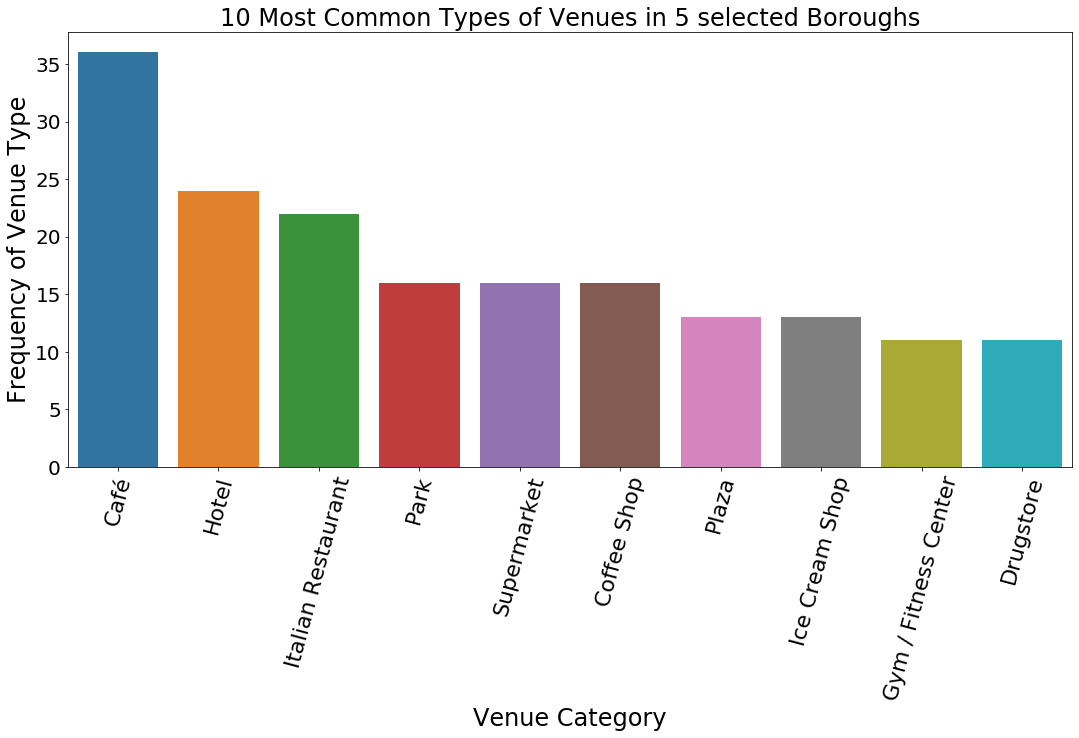

In [26]:
fig = plt.figure(figsize=(18,8))
s=sns.barplot(x="Venue Category", y="Frequency", data = BerlinTop5Boroughs_nearby_venuesTop10)
s.set_xticklabels(s.get_xticklabels(), rotation=75)
plt.title('10 Most Common Types of Venues in 5 selected Boroughs', fontsize=24)
plt.xlabel("Venue Category", fontsize=24)
plt.xticks(fontsize=22)
plt.ylabel ("Frequency of Venue Type", fontsize=24)
plt.yticks(fontsize=20)
#plt.savefig("Most_Freq_Venues.png", dpi=400)
plt.show()

It looks like that Cafes or Coffee Shops are most common venue type.

### 3.4.3 Analyze Each Borough

**Now analyze the results further with hot encoding**

In [27]:
### Use One Hot Encoding to Get More Information about the Venue Categories 
BerlinTop5Boroughs_nearby_venues_onehot = pd.get_dummies(BerlinTop5Boroughs_nearby_venues[['Venue Category']], prefix="", prefix_sep="")

### add district column back to dataframe
BerlinTop5Boroughs_nearby_venues_onehot['Boroughs'] = BerlinTop5Boroughs_nearby_venues['Boroughs'] 

### move district column to the first column
fixed_columns = [BerlinTop5Boroughs_nearby_venues_onehot.columns[-1]] + list(BerlinTop5Boroughs_nearby_venues_onehot.columns[:-1])
BerlinTop5Boroughs_nearby_venues_onehot = BerlinTop5Boroughs_nearby_venues_onehot[fixed_columns]

print('the shape of data frame is:', BerlinTop5Boroughs_nearby_venues_onehot.shape)

BerlinTop5Boroughs_nearby_venues_onehot.head()

the shape of data frame is: (500, 158)


,Boroughs,African Restaurant,Art Gallery,Art Museum,Asian Restaurant,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bar,...,Trattoria/Osteria,Turkish Restaurant,Vacation Rental,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Waterfront,Whisky Bar,Wine Bar,Wine Shop,Yoga Studio
0,Charlottenburg-Wilmersdorf,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Charlottenburg-Wilmersdorf,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Charlottenburg-Wilmersdorf,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Charlottenburg-Wilmersdorf,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Charlottenburg-Wilmersdorf,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


**Grouping by Boroughs and and taking the mean of the frequency of occurrence of each category**

In [28]:
# Group the data
BerlinTop5Boroughs_nearby_venues_grouped = BerlinTop5Boroughs_nearby_venues_onehot.groupby('Boroughs').mean().reset_index()
BerlinTop5Boroughs_nearby_venues_grouped.index = np.arange(1, len(BerlinTop5Boroughs_nearby_venues_grouped)+1)
BerlinTop5Boroughs_nearby_venues_grouped

,Boroughs,African Restaurant,Art Gallery,Art Museum,Asian Restaurant,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bar,...,Trattoria/Osteria,Turkish Restaurant,Vacation Rental,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Waterfront,Whisky Bar,Wine Bar,Wine Shop,Yoga Studio
1,Charlottenburg-Wilmersdorf,0.00,0.00,0.00,0.02,0.00,0.00,0.01,0.02,0.00,...,0.06,0.02,0.00,0.01,0.05,0.00,0.00,0.00,0.02,0.00
2,Friedrichshain-Kreuzberg,0.01,0.02,0.00,0.00,0.01,0.00,0.00,0.03,0.06,...,0.01,0.02,0.00,0.00,0.01,0.00,0.00,0.01,0.00,0.03
3,Mitte,0.00,0.02,0.04,0.00,0.00,0.00,0.00,0.00,0.01,...,0.00,0.00,0.01,0.00,0.01,0.02,0.00,0.02,0.00,0.00
4,Pankow,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.03,0.03,...,0.02,0.01,0.00,0.00,0.01,0.00,0.01,0.00,0.01,0.00
5,Tempelhof-Schöneberg,0.00,0.00,0.00,0.01,0.00,0.01,0.00,0.02,0.00,...,0.01,0.00,0.00,0.00,0.01,0.00,0.00,0.00,0.00,0.00


**Print the frequency of top 5 types of venues for each Boroughs**

In [29]:
num_top_venues = 5

for places in BerlinTop5Boroughs_nearby_venues_grouped['Boroughs']:
    print("=========== "+places+" ==========")
    temp = BerlinTop5Boroughs_nearby_venues_grouped[BerlinTop5Boroughs_nearby_venues_grouped['Boroughs'] == places].T.reset_index()
    #temp.T.index = np.arange(1, len(temp.T)+1)
    temp.columns = ['Venue','Freq']
    temp = temp.iloc[1:]
    temp['Freq'] = temp['Freq'].astype(float)
    temp = temp.round({'Freq': 2})
    print(temp.sort_values('Freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

=========== Charlottenburg-Wilmersdorf ==========
                   Venue  Freq
0     Italian Restaurant  0.10
1                   Café  0.09
2                  Hotel  0.06
3      Trattoria/Osteria  0.06
4  Vietnamese Restaurant  0.05


=========== Friedrichshain-Kreuzberg ==========
            Venue  Freq
0     Coffee Shop  0.09
1             Bar  0.06
2  Ice Cream Shop  0.05
3            Café  0.05
4     Yoga Studio  0.03


=========== Mitte ==========
                 Venue  Freq
0                Hotel  0.12
1                Plaza  0.06
2         Concert Hall  0.05
3           Art Museum  0.04
4  Monument / Landmark  0.04


=========== Pankow ==========
                Venue  Freq
0                Café  0.15
1         Supermarket  0.06
2                Park  0.05
3  Italian Restaurant  0.04
4           Drugstore  0.04


=========== Tempelhof-Schöneberg ==========
                Venue  Freq
0                Park  0.08
1         Supermarket  0.07
2                Café  0.05
3  Ital

**Place the data into a dataframe of the most popular venues for each boroughs.**

In [30]:
## Define a Function to select the top 10 rows (According to the Values) 

def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [31]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Boroughs']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
BerlinTop5Boroughs_nearby_venues_sorted = pd.DataFrame(columns=columns)
BerlinTop5Boroughs_nearby_venues_sorted['Boroughs'] = BerlinTop5Boroughs_nearby_venues_grouped['Boroughs']

for ind in np.arange(BerlinTop5Boroughs_nearby_venues_grouped.shape[0]):
    BerlinTop5Boroughs_nearby_venues_sorted.iloc[ind, 1:] = return_most_common_venues(BerlinTop5Boroughs_nearby_venues_grouped.iloc[ind, :], num_top_venues)

    
BerlinTop5Boroughs_nearby_venues_sorted.index = np.arange(1, len(BerlinTop5Boroughs_nearby_venues_sorted)+1)
BerlinTop5Boroughs_nearby_venues_sorted

,Boroughs,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
1,Charlottenburg-Wilmersdorf,Italian Restaurant,Café,Hotel,Trattoria/Osteria,Vietnamese Restaurant,Gym / Fitness Center,Ice Cream Shop,German Restaurant,Plaza,Steakhouse
2,Friedrichshain-Kreuzberg,Coffee Shop,Bar,Ice Cream Shop,Café,Yoga Studio,Hotel,Bakery,Italian Restaurant,French Restaurant,Falafel Restaurant
3,Mitte,Hotel,Plaza,Concert Hall,Monument / Landmark,Art Museum,Hotel Bar,Chocolate Shop,Bookstore,Shopping Mall,Coffee Shop
4,Pankow,Café,Supermarket,Park,Italian Restaurant,Drugstore,Bakery,Coffee Shop,Ice Cream Shop,Bar,Organic Grocery
5,Tempelhof-Schöneberg,Park,Supermarket,Café,Italian Restaurant,Drugstore,Gym / Fitness Center,Doner Restaurant,Historic Site,Sandwich Place,Shopping Mall


**Find the total number of Restaurants, Coffee Shops and Hotels in each Boroughs; and Visualize**

In [32]:
# Group by 'restaurant', 'Cafe' and 'Hotel' 
search4Restaurants = ['Restaurant']
search4CoffeeShops = ['Caf'] # In Cafe, the main focus is on food rather than coffee.
search4Hotels = ['Hotel']

BerlinTop5Boroughs_nearby_venues_restaurant = BerlinTop5Boroughs_nearby_venues.groupby(['Boroughs'])['Venue Category'].apply(lambda x: x[x.str.contains('|'.join(search4Restaurants))].count())
BerlinTop5Boroughs_nearby_venues_cafe = BerlinTop5Boroughs_nearby_venues.groupby(['Boroughs'])['Venue Category'].apply(lambda x: x[x.str.contains('|'.join(search4CoffeeShops))].count())
BerlinTop5Boroughs_nearby_venues_hotel = BerlinTop5Boroughs_nearby_venues.groupby(['Boroughs'])['Venue Category'].apply(lambda x: x[x.str.contains('|'.join(search4Hotels))].count())

df_berlinTop5Boroughs_restaurant = BerlinTop5Boroughs_nearby_venues_restaurant.to_frame().reset_index()
df_berlinTop5Boroughs_cafe = BerlinTop5Boroughs_nearby_venues_cafe.to_frame().reset_index()
df_berlinTop5Boroughs_hotel = BerlinTop5Boroughs_nearby_venues_hotel.to_frame().reset_index()

df_berlinTop5Boroughs_restaurant.columns = ['Boroughs', 'Number of Restaurants']
df_berlinTop5Boroughs_cafe.columns = ['Boroughs', 'Number of Cafes']
df_berlinTop5Boroughs_hotel.columns = ['Boroughs', 'Number of Hotels']

df_berlinTop5Boroughs_cafeRestaurant = df_berlinTop5Boroughs_restaurant.merge(df_berlinTop5Boroughs_cafe, on = 'Boroughs')
df_berlinTop5Boroughs_cafeRestaurantHotel = df_berlinTop5Boroughs_cafeRestaurant.merge(df_berlinTop5Boroughs_hotel, on = 'Boroughs')

df_berlinTop5Boroughs_cafeRestaurantHotel.index = np.arange(1, len(df_berlinTop5Boroughs_cafeRestaurantHotel)+1)

list_top5Boroughs = df_berlinTop5Boroughs_cafeRestaurantHotel['Boroughs'].to_list()
list_totalRestaurant_Boroughs = df_berlinTop5Boroughs_cafeRestaurantHotel['Number of Restaurants'].to_list()
list_totalCafe_Boroughs = df_berlinTop5Boroughs_cafeRestaurantHotel['Number of Cafes'].to_list()
list_totalHotel_Boroughs = df_berlinTop5Boroughs_cafeRestaurantHotel['Number of Hotels'].to_list()

# Print DataType, shape and DataFrame called df_berlin
print("Data types of each columns:\n", df_berlinTop5Boroughs_cafeRestaurantHotel.dtypes)
print("\nThe shape of dataFrame is:", df_berlinTop5Boroughs_cafeRestaurantHotel.shape)
df_berlinTop5Boroughs_cafeRestaurantHotel

Data types of each columns:
 Boroughs                 object
Number of Restaurants     int64
Number of Cafes           int64
Number of Hotels          int64
dtype: object

The shape of dataFrame is: (5, 4)


,Boroughs,Number of Restaurants,Number of Cafes,Number of Hotels
1,Charlottenburg-Wilmersdorf,37,9,6
2,Friedrichshain-Kreuzberg,24,5,4
3,Mitte,7,2,14
4,Pankow,20,15,2
5,Tempelhof-Schöneberg,21,5,1


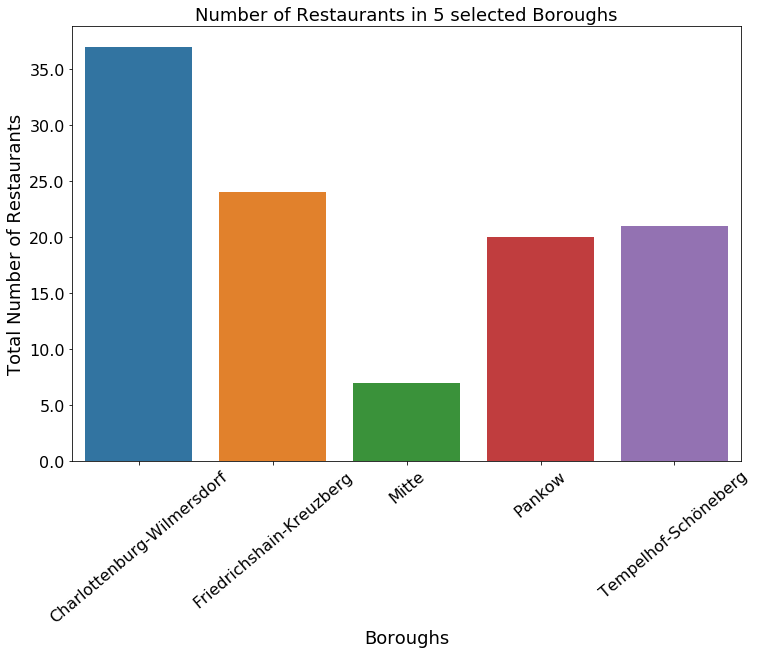

In [33]:
fig = plt.figure(figsize=(12,8))
bar = sns.barplot(x='Boroughs', y='Number of Restaurants', data=df_berlinTop5Boroughs_cafeRestaurantHotel)

bar.set_ylabel("Total Number of Restaurants", fontsize=18)
bar.set_xlabel("Boroughs", fontsize=18)
bar.set_xticklabels(bar.get_xticklabels(),rotation=40, fontsize=16)
bar.set_yticklabels(bar.get_yticks(), size=16)
bar.set_title("Number of Restaurants in 5 selected Boroughs", fontsize=18)
#plt.savefig("No_of_Rest_in_selected_boroughs.png", dpi=240)
plt.show()

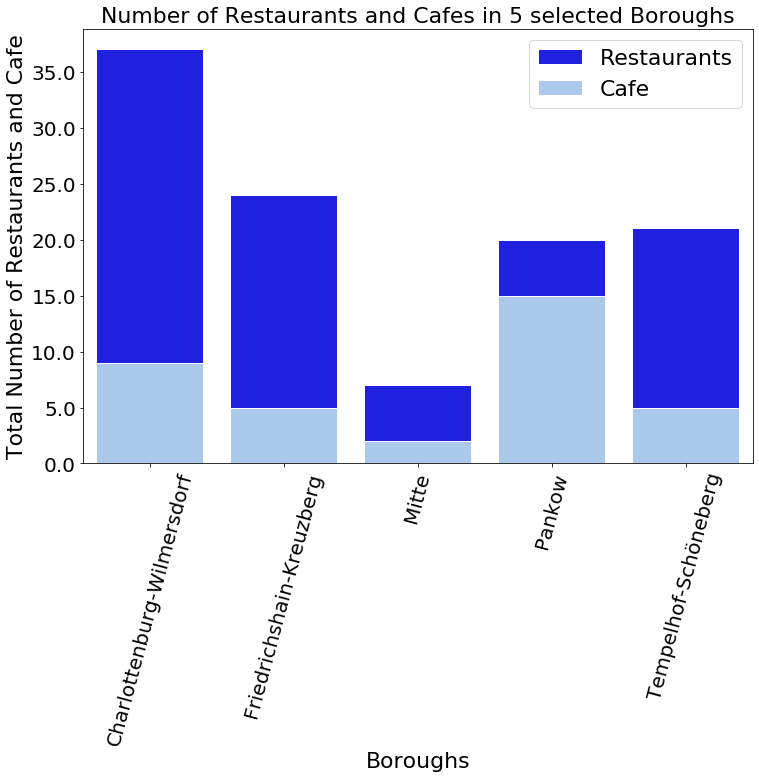

In [34]:
fig = plt.figure(figsize=(12,8))
bar = sns.barplot(x='Boroughs', y='Number of Restaurants', data = df_berlinTop5Boroughs_cafeRestaurantHotel, label = 'Restaurants', color='b', edgecolor='w')
sns.set_color_codes('pastel')
bar = sns.barplot(x='Boroughs', y='Number of Cafes', data = df_berlinTop5Boroughs_cafeRestaurantHotel, label = 'Cafe', color='b', edgecolor='w')
sns.set_color_codes('muted')

bar.legend(ncol = 1, loc = 'upper right', fontsize=22)
bar.set_ylabel("Total Number of Restaurants and Cafe", fontsize=22)
bar.set_xlabel("Boroughs", fontsize=22)
bar.set_xticklabels(bar.get_xticklabels(), rotation=75, fontsize=20)
bar.set_yticklabels(bar.get_yticks(), size=20)
bar.set_title("Number of Restaurants and Cafes in 5 selected Boroughs", fontsize=22)
#plt.savefig("No_of_RestaurantCafe_in_selected_boroughs.png", dpi=240)
plt.show()

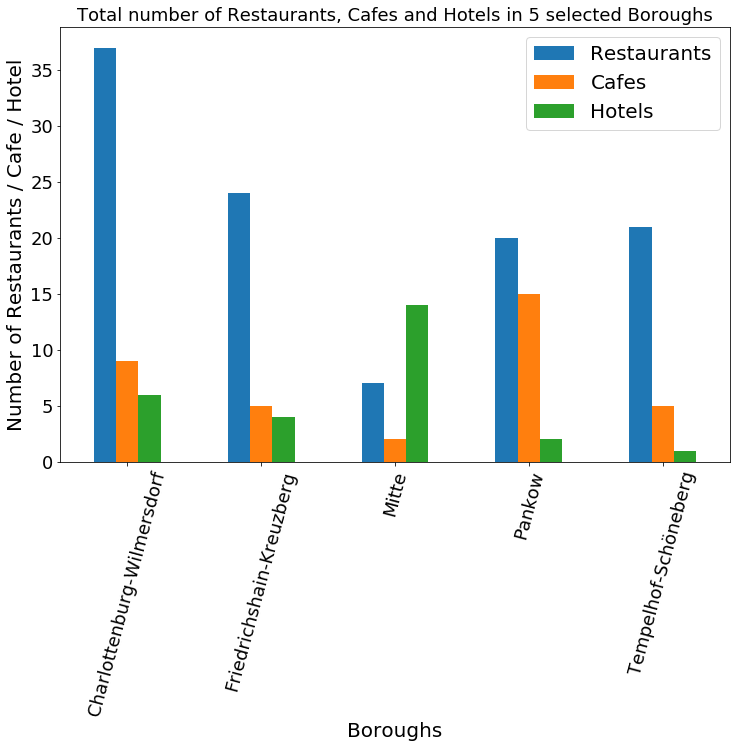

In [35]:
plotData = df_berlinTop5Boroughs_cafeRestaurantHotel.rename(columns={'Number of Restaurants':'Restaurants', 'Number of Cafes':'Cafes', 'Number of Hotels':'Hotels'})
plotData.plot(kind="bar", x="Boroughs", title = 'Total number of Restaurants, Cafe and Hotels in selected 5 Boroughs', figsize=(12,8))
plt.title('Total number of Restaurants, Cafes and Hotels in 5 selected Boroughs', fontsize=18)
plt.xlabel("Boroughs", fontsize=20)
plt.ylabel("Number of Restaurants / Cafe / Hotel", fontsize=20)
plt.xticks(fontsize=18,rotation=75)
plt.yticks(fontsize=18)
plt.legend(ncol = 1, loc = 'upper right', fontsize=20)
#plt.savefig("No_of_RestaurantCafeHotels_in_selected_boroughs.png", dpi=240)
plt.show()

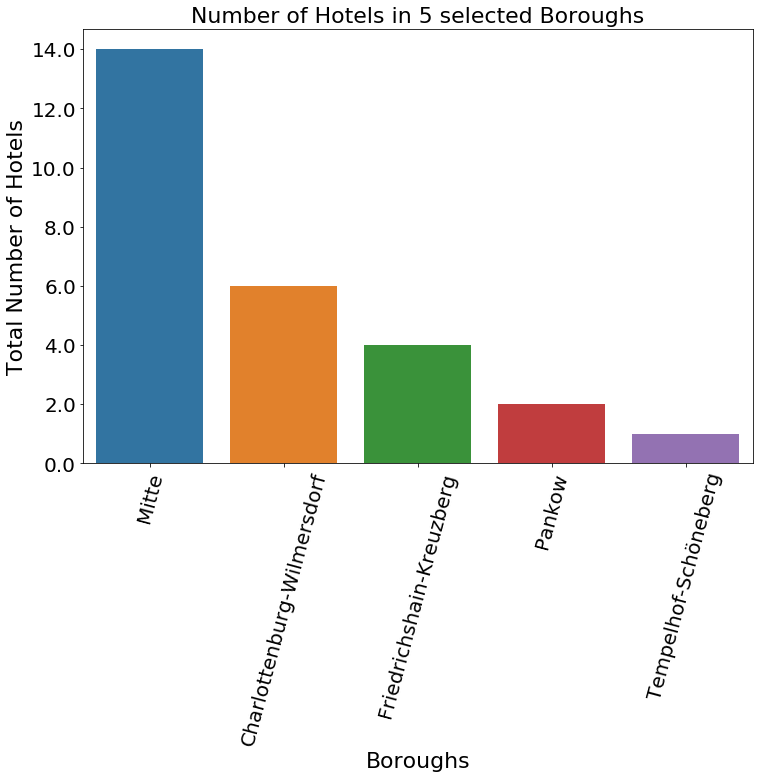

In [36]:
plotDataFrame = df_berlinTop5Boroughs_cafeRestaurantHotel.rename(columns={'Number of Restaurants':'Restaurants', 'Number of Cafes':'Cafes', 'Number of Hotels':'Hotels'})
plotData = plotDataFrame.loc[:,['Boroughs', 'Hotels']]
plotData.sort_values(by=['Hotels'], inplace = True, ascending=False)

fig = plt.figure(figsize=(12,8))
bar = sns.barplot(x='Boroughs', y='Hotels', data=plotData)
bar.set_ylabel("Total Number of Hotels", fontsize=22)
bar.set_xlabel("Boroughs", fontsize=22)
bar.set_xticklabels(bar.get_xticklabels(),rotation=75, fontsize=20)
bar.set_yticklabels(bar.get_yticks(), size=20)
bar.set_title("Number of Hotels in 5 selected Boroughs", fontsize=22)
#plt.savefig("No_of_Hotels_in_selected_boroughs.png", dpi=240)
plt.show()


**Visualize the Restaurants in 5 selected boroughs on Folium leaflet map**

In [37]:
# Create a Data-Frame out of it to Concentrate Only on Restaurants
search4Restaurants = ['Restaurant']
BerlinTop5Boroughs_nearby_venues_only_restaurant = BerlinTop5Boroughs_nearby_venues[BerlinTop5Boroughs_nearby_venues['Venue Category']\
                                                          .str.contains('|'.join(search4Restaurants))].reset_index(drop=True)
BerlinTop5Boroughs_nearby_venues_only_restaurant.index = np.arange(1, len(BerlinTop5Boroughs_nearby_venues_only_restaurant)+1)
print ("Shape of the Data-Frame with Venue Category only Restaurant: ", BerlinTop5Boroughs_nearby_venues_only_restaurant.shape)
#BerlinTop5Boroughs_nearby_venues_only_restaurant



## Show in Map the Top Rated Restaruants in the Top 5 Boroughs
map_restaurantsOnly = folium.Map(location=[Berlin_lat, Berlin_lng], zoom_start=11, tiles="openstreetmap", 
                            attr="<a href=https://github.com/python-visualization/folium/>Folium</a>")

# set color scheme for the Venues based on borooughs
Top5Boroughs = list(df_berlinTop5Boroughs['Boroughs'])

x = np.arange(len(Top5Boroughs))

rainbow = ['#00ff00', '#ff00ff','#0000ff','#ffa500' ,'#ff0000']

title_html =  '<h3 align="center" style="font-size:15px"><b>Most frequently visited restaurants in 5 selected Boroughs</b></h3>'
map_restaurantsOnly.get_root().html.add_child(folium.Element(title_html))

# add markers to the map
# markers_colors = []
for lat, lon, poi, bor in zip(BerlinTop5Boroughs_nearby_venues_only_restaurant['Venue Latitude'], 
                                  BerlinTop5Boroughs_nearby_venues_only_restaurant['Venue Longitude'], 
                                  BerlinTop5Boroughs_nearby_venues_only_restaurant['Venue Category'], 
                                  BerlinTop5Boroughs_nearby_venues_only_restaurant['Boroughs']):
    label = folium.Popup(str(poi) + ' ' + str(bor), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=7,
        popup=label,
        color=rainbow[Top5Boroughs.index(bor)-1],
        fill=True,
        fill_color=rainbow[Top5Boroughs.index(bor)-1],
        fill_opacity=0.3).add_to(map_restaurantsOnly)

map_restaurantsOnly

Shape of the Data-Frame with Venue Category only Restaurant:  (109, 7)


**Visualize the Cafes in 5 selected boroughs on Folium leaflet map**

In [38]:
## Create a Data-Frame out of it to Concentrate Only on Coffee shops
search4Coffee = ['Caf']
BerlinTop5Boroughs_nearby_venues_only_cafe = BerlinTop5Boroughs_nearby_venues[BerlinTop5Boroughs_nearby_venues['Venue Category']\
                                                          .str.contains('|'.join(search4Coffee))].reset_index(drop=True)
BerlinTop5Boroughs_nearby_venues_only_cafe.index = np.arange(1, len(BerlinTop5Boroughs_nearby_venues_only_cafe)+1)
print ("Shape of the Data-Frame with Venue Category only Cafe: ", BerlinTop5Boroughs_nearby_venues_only_cafe.shape)
#BerlinTop5Boroughs_nearby_venues_only_cafe


## Show in Map the Top Rated Coffee Shops in the Top 5 Boroughs
map_cafeOnly = folium.Map(location=[Berlin_lat, Berlin_lng], zoom_start=11, tiles="openstreetmap", 
                            attr="<a href=https://github.com/python-visualization/folium/>Folium</a>")

# set color scheme for the Venues based on the boroughs
Top5Boroughs = list(df_berlinTop5Boroughs['Boroughs'])

x = np.arange(len(Top5Boroughs))

rainbow = ['#00ff00', '#ff00ff','#0000ff','#ffa500' ,'#ff0000']

title_html =  '<h3 align="center" style="font-size:15px"><b>Most frequently visited cafe in 5 selected Boroughs</b></h3>'
map_cafeOnly.get_root().html.add_child(folium.Element(title_html))

# add markers to the map
for lat, lon, poi, bor in zip(BerlinTop5Boroughs_nearby_venues_only_cafe['Venue Latitude'], 
                                  BerlinTop5Boroughs_nearby_venues_only_cafe['Venue Longitude'], 
                                  BerlinTop5Boroughs_nearby_venues_only_cafe['Venue Category'], 
                                  BerlinTop5Boroughs_nearby_venues_only_cafe['Boroughs']):
    label = folium.Popup(str(poi) + ' ' + str(bor), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=7,
        popup=label,
        color=rainbow[Top5Boroughs.index(bor)-1],
        fill=True,
        fill_color=rainbow[Top5Boroughs.index(bor)-1],
        fill_opacity=0.3).add_to(map_cafeOnly)
       
map_cafeOnly

Shape of the Data-Frame with Venue Category only Cafe:  (36, 7)


## 3.5 Neighborhood Clustering using K-Means Clustering

### 3.5.1 K-Means Clustering
Clustering the selected boroughs for more insights using K-Means clustering

In [39]:
# set nubmer of clusters
k_clusters = 3

berlin_grouped_clustering = BerlinTop5Boroughs_nearby_venues_grouped.drop('Boroughs', 1)

# Run the K-Means clustering
kmeans = KMeans(n_clusters = k_clusters, random_state = 0).fit(berlin_grouped_clustering)

print('Generated cluster labels', kmeans.labels_)

# add the clustering labels
if 'Cluster Labels' in BerlinTop5Boroughs_nearby_venues_sorted.columns:
    BerlinTop5Boroughs_nearby_venues_sorted.drop(columns=['Cluster Labels'], axis=1, inplace=True)
    BerlinTop5Boroughs_nearby_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)
else:
    BerlinTop5Boroughs_nearby_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)


berlin_nearby_merged = df_berlinTop5Boroughs

# merge berlin_nearby_merged with berlinTop5Boroughs data to add latitude/longitude for each Boroughs
berlin_nearby_merged = berlin_nearby_merged.join(BerlinTop5Boroughs_nearby_venues_sorted.set_index('Boroughs'), on='Boroughs')

# Also add the calculated restaurant, coffee shops and hotels for each boroughs
berlin_nearby_merged = berlin_nearby_merged.join(df_berlinTop5Boroughs_cafeRestaurantHotel.set_index('Boroughs'), on='Boroughs')

# Print DataType, shape and DataFrame called df_berlin
#print("Data types of each columns:\n", berlin_nearby_merged.dtypes)
print("\nThe shape of dataFrame is:", berlin_nearby_merged.shape)
berlin_nearby_merged # check the last 3 columns!

Generated cluster labels [0 2 1 0 0]

The shape of dataFrame is: (5, 23)


,Boroughs,Neighborhoods,Area_sqkm,Population,Total Businesses,Total Visitors in 2019,Rent Price in 2019 [€/m²-month],Latitude,Longitude,Cluster Labels,...,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,Number of Restaurants,Number of Cafes,Number of Hotels
1,Charlottenburg-Wilmersdorf,"Charlottenburg, Wilmersdorf, Schmargendorf, Gr...",64.62,342332,29324,9157433,13.0,52.498889,13.284917,0,...,Trattoria/Osteria,Vietnamese Restaurant,Gym / Fitness Center,Ice Cream Shop,German Restaurant,Plaza,Steakhouse,37,9,6
2,Mitte,"Mitte, Moabit, Hansaviertel, Tiergarten, Weddi...",39.48,384172,28553,20809270,14.0,52.516667,13.366667,1,...,Monument / Landmark,Art Museum,Hotel Bar,Chocolate Shop,Bookstore,Shopping Mall,Coffee Shop,7,2,14
3,Pankow,"Prenzlauer Berg, Weißensee, Blankenburg, Heine...",103.26,407765,22628,1924337,12.1,52.568889,13.402222,0,...,Italian Restaurant,Drugstore,Bakery,Coffee Shop,Ice Cream Shop,Bar,Organic Grocery,20,15,2
4,Friedrichshain-Kreuzberg,"Friedrichshain, Kreuzberg",20.18,289762,20978,6495909,13.6,52.500000,13.433333,2,...,Café,Yoga Studio,Hotel,Bakery,Italian Restaurant,French Restaurant,Falafel Restaurant,24,5,4
5,Tempelhof-Schöneberg,"Schöneberg, Friedenau, Tempelhof, Mariendorf, ...",53.08,351644,18926,2948106,11.8,52.466667,13.383333,0,...,Italian Restaurant,Drugstore,Gym / Fitness Center,Doner Restaurant,Historic Site,Sandwich Place,Shopping Mall,21,5,1


### 3.3.2 Visualization of the resulting clusters

In [40]:
# create map
map_clusters = folium.Map(location=[Berlin_lat, Berlin_lng], zoom_start=11, tiles="openstreetmap", 
                            attr="<a href=https://github.com/python-visualization/folium/>Folium</a>")

# set color scheme for the clusters
x = np.arange(k_clusters)
ys = [i + x + (i*x)**2 for i in range(k_clusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, bor, cluster in zip(berlin_nearby_merged['Latitude'], 
                                  berlin_nearby_merged['Longitude'], 
                                  berlin_nearby_merged['Boroughs'], 
                                  berlin_nearby_merged['Cluster Labels']):
    label = folium.Popup(str(bor) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=20,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

**Visualize the Clusters in which size of Clusters represent the Number of Restaurants in each Boroughs**

In [41]:
map_restaurants = folium.Map(location=[Berlin_lat, Berlin_lng], zoom_start=11, tiles='cartodbpositron', 
                               attr="<a href=https://github.com/python-visualization/folium/>Folium</a>")

# set color scheme for the clusters
x = np.arange(k_clusters)
ys = [i + x + (i*x)**2 for i in range(k_clusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

title_html =  '<h3 align="center" style="font-size:15px"><b>3 Clusters: Radius of Cluster corresponds to Number of Restaurants in each Borough</b></h3>'
map_restaurants.get_root().html.add_child(folium.Element(title_html))
             
# add markers to the map
markers_colors = []
for lat, lon, bor, cluster, rest, cafe in zip(berlin_nearby_merged['Latitude'], 
                                  berlin_nearby_merged['Longitude'], 
                                  berlin_nearby_merged['Boroughs'], 
                                  berlin_nearby_merged['Cluster Labels'],
                                  berlin_nearby_merged['Number of Restaurants'],
                                  berlin_nearby_merged['Number of Cafes']):
    label = folium.Popup(str(bor) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=rest*2,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_restaurants)

map_restaurants

**Visualize the Clusters in which size of Clusters represent the Number of Cafe and Restaurants together in each Boroughs**

In [42]:
map_cafe = folium.Map(location=[Berlin_lat, Berlin_lng], zoom_start=11, tiles='cartodbpositron', 
                               attr="<a href=https://github.com/python-visualization/folium/>Folium</a>")


# set color scheme for the clusters
x = np.arange(k_clusters)
ys = [i + x + (i*x)**2 for i in range(k_clusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

title_html =  '<h3 align="center" style="font-size:15px"><b>3 Clusters: Radius of Cluster corresponds to Number of Cafe and Restaurant together in each Borough</b></h3>'
map_cafe.get_root().html.add_child(folium.Element(title_html))
             
# add markers to the map
markers_colors = []
for lat, lon, bor, cluster, rest, cafe in zip(berlin_nearby_merged['Latitude'], 
                                  berlin_nearby_merged['Longitude'], 
                                  berlin_nearby_merged['Boroughs'], 
                                  berlin_nearby_merged['Cluster Labels'],
                                  berlin_nearby_merged['Number of Restaurants'],
                                  berlin_nearby_merged['Number of Cafes']):
    label = folium.Popup(str(bor) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=(rest+cafe)*2,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_cafe)

map_cafe

# 4. Results and Discussion <a name="ResultsDiscussion"></a>

To find a best spot in Berlin for opening a café cum restaurant, we have retrieved Berlin’s geographic, business, tourist and rent price datasets for all 12 boroughs of berlin from various sources, and then explored these datasets for the preferred 5 boroughs and analyzed mainly on the restaurant and café. At the end, our analysis shows us that:

* 43% of total tourists in Berlin are hosted by only Mitte borough, whereas another four boroughs together host 43% of total tourist in Berlin.   
* 30% of total businesses of berlin are in Charlottenburg-Wilmersdorf (15.26%) and Mitte (14.86%) boroughs; whereas Pankow, Friedrichshain-Kreuzberg and Tempelhof-Schöneberg boroughs cover another 31.7% of total businesses.
* The most common venues in the preferred 5 boroughs are Café, followed by Hotel, Italian Restaurant, Park, Supermarket and Coffee Shops.
* Charlottenburg-Wilmersdorf, Friedrichshain-Kreuzberg, Pankow and Tempelhof-Schöneberg boroughs have restaurants and cafés as popular venues, whereas Mitte borough is dominated by Hotel. 
* Boroughs clustering based on their most popular venues grouped Charlottenburg-Wilmersdorf, Pankow with Tempelhof-Schöneberg into a cluster, and Mitte and Friedrichshain-Kreuzberg as their own independent clusters.
* According to Homeday.de report, the Mitte, Friedrichshain-Kreuzberg and Charlottenburg-Wilmersdorf boroughs are expensive places to live with rent price 14, 13.6 and 13 €/m²-month, respectively.
* Tempelhof-Schöneberg and Pankow boroughs are more affordable with 11.8 and 12.1 €/m²-month, respectively.

According to this analysis, Mitte and Charlottenburg-Wilmersdorf boroughs are more favorable to starting a café cum restaurant compare to the other boroughs despite of having a high cost of rent. Because, both boroughs have a very high foot traffic by business employees and tourists compared to any other boroughs. Out of Mitte and Charlottenburg-Wilmersdorf, Mitte borough will provide least competition for café cum restaurant as the frequency of café-restaurant as common venue is very low compared to the Charlottenburg-Wilmersdorf. Moreover, the number of tourists in Mitte borough is almost 2.3 times than Charlottenburg-Wilmersdorf. Hence, Mitte borough can be best choice to open a café cum restaurant.

Some major drawbacks of this analysis - the boroughs clustering is completely based on the most popular venues obtained from Foursquare data; the business and tourists data for each boroughs rather than the neighborhood; average rent price of boroughs – all these play major role in the analysis.


# 5. Conclusion <a name="Conclusion"></a>

In this data science project, I have retrieved, explored, and analyzed the sets of Berlin’s business, tourist, and geographical data to find out the best spot for opening a café cum restaurant; and discussed the results in great detail. Through this project, I have made to use various analytical tools like the use of python libraries to scrape and manipulate the data sets, Foursquare API to explore the neighborhoods, and Folium leaflet map to visualize the clusters. This experience of use of these analytical tools helped me to understand that how a real-life business problem can be solved by using various data science tools.

# 6. References <a name="References"></a>
[1]. Berlin.de, The Official Website of Berlin, Germany, accessed 21 July 2020, https://www.berlin.de/sen/wirtschaft/wirtschaft/branchen/tourismus/tourismus-in-zahlen/ <br>
[2]. Berliner Wirtschaft 2019 stark gewachsen, Wirtschaft aktuell, Senatsverwaltung für Wirtschaft, Energie und Betriebe, Germany, April 2020. <br>
[3]. Economic Development, The Official Website of Berlin, Germany, accessed 21 July 2020, https://www.berlin.de/en/business-and-economy/economic-center/5611367-4011028-economic-development.en.html <br>
[4]. Verwaltungsgliederung Berlins, accessed 21 July 2020. In Wikipedia. Retrieved from  https://de.wikipedia.org/wiki/Verwaltungsgliederung_Berlins <br>
[5]. Amt für Statistik Berlin-Brandenburg; Germany, accessed 21 July 2020, https://www.statistik-berlin-brandenburg.de/datenbank/inhalt-datenbank.asp <br>
[6]. Homeday.de, Homeday mein Immobilienmakler, accessed 25 July 2020, https://www.homeday.de/de/blog/mietpreise-berlin-2019/